# Проект: Оценка результатов A/B-теста. #

## Описание проекта : ##

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

<b>Цели исследования</b>:

- Оценика корректности проведения теста;
- Анализ результата теста.

### Описание данных : ###

<b>ab_project_marketing_events.csv</b> — календарь маркетинговых событий на 2020 год.

*Структура файла:*

- <b>name</b> — название маркетингового события;
- <b>regions</b> — регионы, в которых будет проводиться рекламная кампания;
- <b>start_dt</b> — дата начала кампании;
- <b>finish_dt</b> — дата завершения кампании.

<b>final_ab_new_users.csv</b> — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

*Структура файла:*

- <b>user_id</b> — идентификатор пользователя;
- <b>first_date</b> — дата регистрации;
- <b>region</b> — регион пользователя;
- <b>device</b> — устройство, с которого происходила регистрация.

<b>final_ab_events.csv</b> — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

*Структура файла:*

- <b>user_id</b> — идентификатор пользователя;
- <b>event_dt</b> — дата и время события;
- <b>event_name</b> — тип события;
- <b>details</b> — дополнительные данные о событии. Например, для покупок, <b>purchase</b>, в этом поле хранится стоимость покупки в долларах.

<b>final_ab_participants.csv</b> — таблица участников тестов.

*Структура файла:*

- <b>user_id</b> — идентификатор пользователя;
- <b>ab_test</b> — название теста;
- <b>group</b> — группа пользователя.


### Техническое задание : ###

- Название теста: <b>recommender_system_test</b>;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие <b>product_page</b>,
    - просмотры корзины — <b>product_cart</b>,
    - покупки — <b>purchase</b>.

## Загрузим файлы с данными и изучим общую информацию. ##

In [3]:
# загружаем библиотеки.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import math as mth
from scipy import stats as st
import plotly.io as pio
pio.renderers.default = 'png'

In [2]:
# считываем данные. 
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv') 
ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [4]:
# функция для выведения общений информации о датафрейме.
def description (df_1, df_2, df_3, df_4):
    for i in (df_1, df_2, df_3, df_4):
        display(i.head())
        print()
        print(i.info())
        print()
        print('Кол-во дубликатов в датасете:', i.duplicated().sum())   

In [5]:
# применение функции
description(marketing_events, new_users, ab_events, ab_participants)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None

Кол-во дубликатов в датасете: 0


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None

Кол-во дубликатов в датасете: 0


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None

Кол-во дубликатов в датасете: 0


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None

Кол-во дубликатов в датасете: 0


<span style='color:#00541F'><b>ВЫВОД ПО РАЗДЕЛУ:</b></span><br>

Датафрейм <b>marketing_events</b>:

- Файл с данными имеет <b>14</b> строк и <b>4</b> столбца; 
- Типы данных в столбцах <b>start_dt</b> и <b>finish_dt</b> не соответствуют значениям; 
- Явные дубликаты в данных отсутствуют.

Датафрейм <b>new_users</b>:

- Файл с данными имеет <b>61733</b> строк и <b>4</b> столбца; 
- Тип данных в столбце <b>first_date</b> не соответствуют значению; 
- Явные дубликаты в данных отсутствуют.

Датафрейм <b>ab_events</b>:

- Файл с данными имеет <b>440317</b> строк и <b>4</b> столбца; 
- Тип данных в столбце <b>event_dt</b> не соответствуют значению;
- В столбце <b>details</b> присутствует только (<b>62740</b>) <b>14%</b> значений от общего количества;
- Явные дубликаты в данных отсутствуют.

Датафрейм <b>ab_participants</b>:

- Файл с данными имеет <b>18268</b> строк и <b>4</b> столбца; 
- Тип данных в столбцах соответствуют значениям; 
- Явные дубликаты в данных отсутствуют.

## Предобработаем данные. ##

In [6]:
# преобразование данных столбцов start_dt и finish_dt к типу datetime.
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

# преобразование данных столбца first_date к типу datetime.
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

# преобразование данных столбца event_dt к типу datetime.
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

In [7]:
# группировка пропущенных значений по событиям.
ab_events.groupby('event_name').count().reset_index()

,event_name,user_id,event_dt,details
0,login,189552,189552,0
1,product_cart,62462,62462,0
2,product_page,125563,125563,0
3,purchase,62740,62740,62740


<span style='color:#00541F'><b>ВЫВОД ПО РАЗДЕЛУ:</b></span><br>

- Было произведено преобразование данных столбцов к типу *datetime*; 
- В столбце <b>details</b> есть только полные данные для события <b>purchase</b>, для остальных событий данные отсутствует, что составляет приблизительно <b>86%</b> данных от общего кол-ва. Исходя из того, что данный признак несет дополнительную информацию, мы допускаем такое наличие пропусков и не будем вносить каких либо изменений;
- Данные готовы к работе.

## Оценка корректности проведения теста. ##

- Название теста: recommender_system_test;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page,
- просмотры корзины — product_cart,
- покупки — purchase.

In [8]:
# посмотрим названия и кол-во тестов.
ab_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [9]:
# проверим соответсвие дат.
print('Дата запуска:', new_users['first_date'].min())
print('Дата остановки набора новых пользователей:', new_users['first_date'].max())

Дата запуска: 2020-12-07 00:00:00
Дата остановки набора новых пользователей: 2020-12-23 00:00:00


In [10]:
# в тех. задании обозначена дата 2020-12-21, отбросим  лишнее.
new_users = new_users[new_users['first_date'] <= '2020-12-21']

In [11]:
# проверим внесенные изменения.
print('Дата остановки набора новых пользователей:', new_users['first_date'].max())

Дата остановки набора новых пользователей: 2020-12-21 00:00:00


In [12]:
# проверим дату последнего события.
print('Дата последнего события:', ab_events['event_dt'].max())

Дата последнего события: 2020-12-30 23:36:33


In [13]:
# размер периода исследования.
print('В наличии данные за период размером:', ab_events['event_dt'].max() - ab_events['event_dt'].min())

В наличии данные за период размером: 23 days 23:36:00


In [14]:
# отфильтруем выбранный период и проверим наличие маркетинговых событий.
marketing_events[marketing_events['regions'].str.contains("EU")]\
                .query('(start_dt >= "2020-12-07" & start_dt <= "2021-01-04")\
                or (finish_dt >= "2020-12-07" & finish_dt <= "2021-01-04")\
                or (start_dt < "2020-12-07" & finish_dt > "2021-01-04")')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [15]:
# проверим пользователей,участвующих в обоих тестах.
ab_participants.groupby('user_id')\
               .agg({'ab_test':'nunique'})\
               .query('ab_test > 1')\
               .count()

ab_test    1602
dtype: int64

In [16]:
# проверим пользователей, участвующих в двух группах теста "recommender_system_test"
ab_participants.query('ab_test == "recommender_system_test"')\
                    .groupby('user_id')\
                    .agg({'group':'nunique'})\
                    .query('group > 1')\
                    .count()

group    0
dtype: int64

In [17]:
# сделаем срез по событие recommender_system_test.
participants_rec = ab_participants.query('ab_test == "recommender_system_test"')
participants_rec.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [18]:
# объединим таблицу participants_rec и new_users по общему ключу.
users_rec = participants_rec.merge(new_users, on='user_id')
users_rec.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [19]:
# посмотрим регионы пользователей.
users_rec['region'].value_counts()

EU           6351
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

In [20]:
# посчитаем процент от общего кол-ва.
print('Доля пользователей EU задействованных в тесте, от общего кол-ва пользователей EU: ',
      users_rec['region'].value_counts()[0] / new_users['region'].value_counts()[0], '%')

Доля пользователей EU задействованных в тесте, от общего кол-ва пользователей EU:  0.15 %


In [21]:
# проверим кол-во участников теста.
print('Кол-во участников теста:', users_rec['user_id'].nunique())

Кол-во участников теста: 6701


In [22]:
# распределение по группам.
users_rec['group'].value_counts(normalize=True).round(2)

A    0.57
B    0.43
Name: group, dtype: float64

In [23]:
# объединим таблицу users_events_rec и ab_events по общему ключу.
users_events_rec = users_rec.merge(ab_events, on='user_id')

In [24]:
# отфильтруем по региону EU.
users_events_rec = users_events_rec.query('region == "EU"')

In [25]:
# расчитаем время жизни клиента.
users_events_rec['lifetime'] = (users_events_rec['event_dt'] - users_events_rec['first_date']).dt.days

In [26]:
# проверим кол-во клиентов превышающие 14 дневный lifetime.
users_events_rec.query('lifetime > 14')

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,lifetime
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,18
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,18
5,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_page,NaN,18
7,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,login,NaN,18
55,92CB588012C10D3D,A,recommender_system_test,2020-12-09,EU,PC,2020-12-25 18:11:49,product_page,NaN,16
...,...,...,...,...,...,...,...,...,...,...
23198,DA111496CD9749B0,A,recommender_system_test,2020-12-08,EU,Android,2020-12-24 19:40:50,product_page,NaN,16
23202,DA111496CD9749B0,A,recommender_system_test,2020-12-08,EU,Android,2020-12-24 19:40:49,login,NaN,16
23279,89332BD0C491D0F8,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-29 09:45:04,purchase,4.99,15
23283,89332BD0C491D0F8,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-29 09:45:07,product_page,NaN,15


In [27]:
# сформируем новый датасет в рамка 14 дневного lifetime.
users_events_rec = users_events_rec.query('lifetime <= 14')

<span style='color:#00541F'><b>ВЫВОД ПО РАЗДЕЛУ:</b></span><br>

- Дата запуска и дата остановки набора новых пользователей - корректны;
- Дата остановки: <b>2020-12-30</b>, требуется <b>2021-01-04</b>. Данные за <b>5</b> дней отсутствуют;
- В наличии данные за период размером <b>23</b> дня;
- Были обнаружены <b>2</b> маркетинговое событие, которое непосредственно имеет влияние на поведение пользователей;
- В данных теста recommender_system_test не обнаружено пересечений пользователей между группами А и B;
- В двух конкурирующих тестах участвуют одновременно  <b>1602</b> пользователя;
- Доля пользователей EU задействованных в тесте, от общего кол-ва пользователей EU - <b>15 %</b>;
- Количество участников теста <b>6701</b>, на <b>701</b> больше ожидаемого;
- Тестовые группы распределены не равномерно. Группа «A» - <b>57 %</b>, группа «B» - <b>43 %</b>. 


## Исследовательский анализ данных. ##

### Кол - во событий по пользователям. ###

In [28]:
# посчитаем контрольную и тестовую группы.
users_events_rec['group'].value_counts()

A    17977
B     4851
Name: group, dtype: int64

In [29]:
# посмотрим среднее кол-во совершаемых действий обеих групп.
print('Среднее кол-во действий совершаемых пользователем группы А:', users_events_rec.query('group == "A"').groupby('user_id')['event_name'].count().mean().round(2))
print('Среднее кол-во действий совершаемых пользователем группы B:', users_events_rec.query('group == "B"').groupby('user_id')['event_name'].count().mean().round(2))

Среднее кол-во действий совершаемых пользователем группы А: 6.9
Среднее кол-во действий совершаемых пользователем группы B: 5.53


In [30]:
# построим таблицу с группировкой кол-ва событий по пользователям и группам.
users_group_events = users_events_rec.groupby(['user_id','group'])['event_name'].count().reset_index()
users_group_events

,user_id,group,event_name
0,001064FEAAB631A1,B,6
1,0010A1C096941592,A,12
2,00341D8401F0F665,A,2
3,003DF44D7589BBD4,A,15
4,00505E15A9D81546,A,5
...,...,...,...
3476,FF5B24BCE4387F86,A,9
3477,FF825C1D791989B5,A,8
3478,FF8CF7057415EB29,B,4
3479,FFAE9489C76F352B,A,6


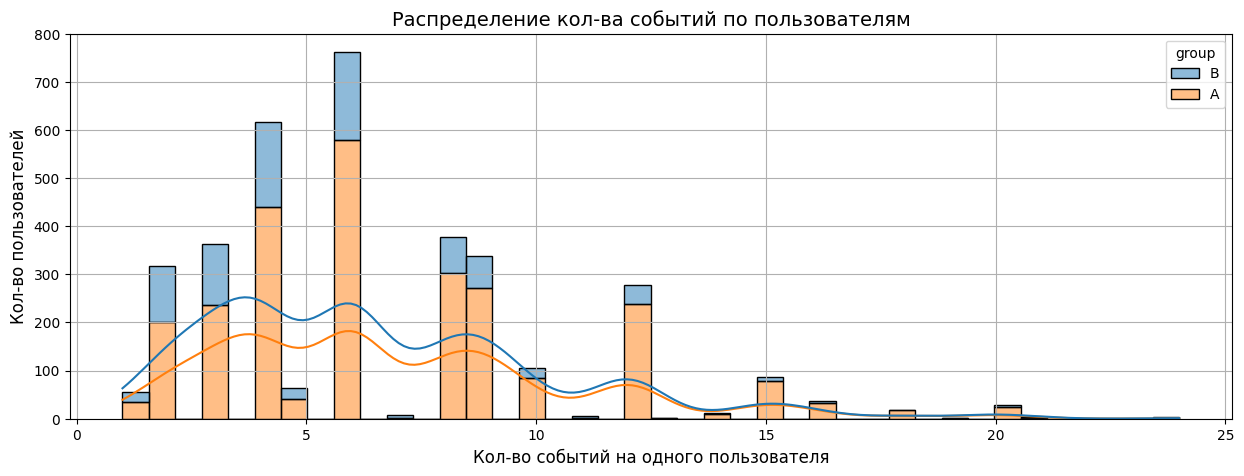

In [31]:
# построим график распределения кол-ва событий по пользователям.
plt.figure(figsize=(15,5))
sns.histplot(data=users_group_events, x='event_name', bins=40, kde=True, hue='group', multiple='stack')
plt.xlabel('Кол-во событий на одного пользователя', fontsize=12)
plt.ylabel('Кол-во пользователей', fontsize=12)
plt.title ('Распределение кол-ва событий по пользователям', fontsize=14)
plt.grid()
plt.show()

### Рапределение кол - ва событий по дням. ###

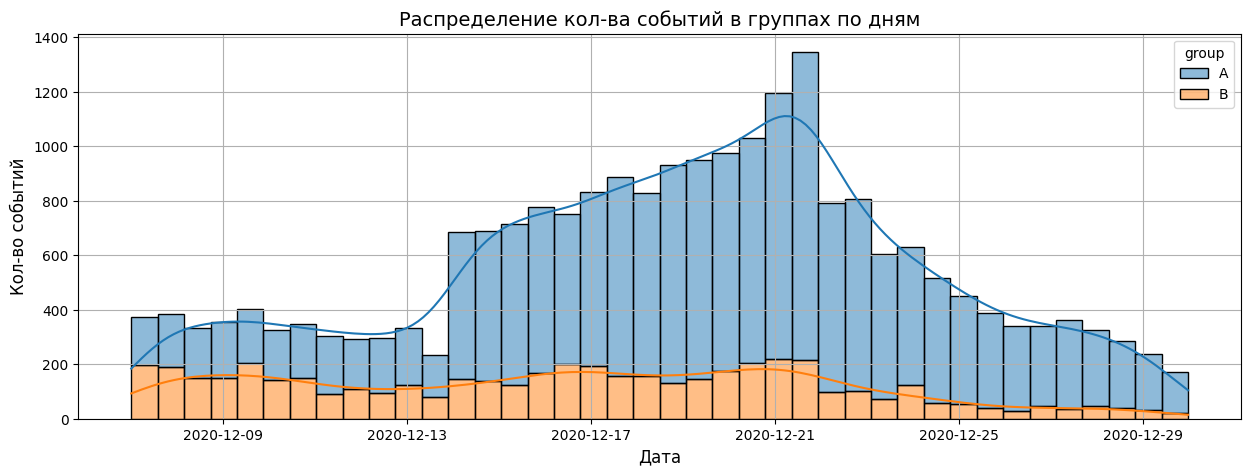

In [33]:
# построим график распределения кол-ва событий в группах по дням.
plt.figure(figsize=(15,5))
sns.histplot(data=users_events_rec, x='event_dt', bins=40, kde=True, hue='group', multiple='stack')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кол-во событий', fontsize=12)
plt.title ('Распределение кол-ва событий в группах по дням', fontsize=14)
plt.grid()
plt.show()

- Резкий всплеск в группе А по событиям пользователей с 14 декабря;
- Кол-во событий в группе А возрастает к 21 декабря. В группе B так же наблюдается рост, но более умеренный;
- Пик активности группы А и B - 21 декабря;
- После своих пиков активности, c 22 декабря наблюдается снижение событий в обеих группах;
- Рост активности объясняется кануном новогодних празников, в частности Рождеством по григорианскому календарю.

### Конверсия в воронке в выборках на разных этапах. ###

In [34]:
# посмотрим кол-во пользователей в каждой группе.
users_events_rec.groupby('group')['user_id'].nunique()

group
A    2604
B     877
Name: user_id, dtype: int64

In [35]:
# построим таблицу с количеством пользователей каждой группы и разобъем её на шаги воронки.
funnel_events = users_events_rec.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')\
                             .reindex(['login', 'product_page', 'product_cart', 'purchase'])\
                             .reset_index()
funnel_events

group,event_name,A,B
0,login,2604,876
1,product_page,1685,493
2,product_cart,782,244
3,purchase,833,249


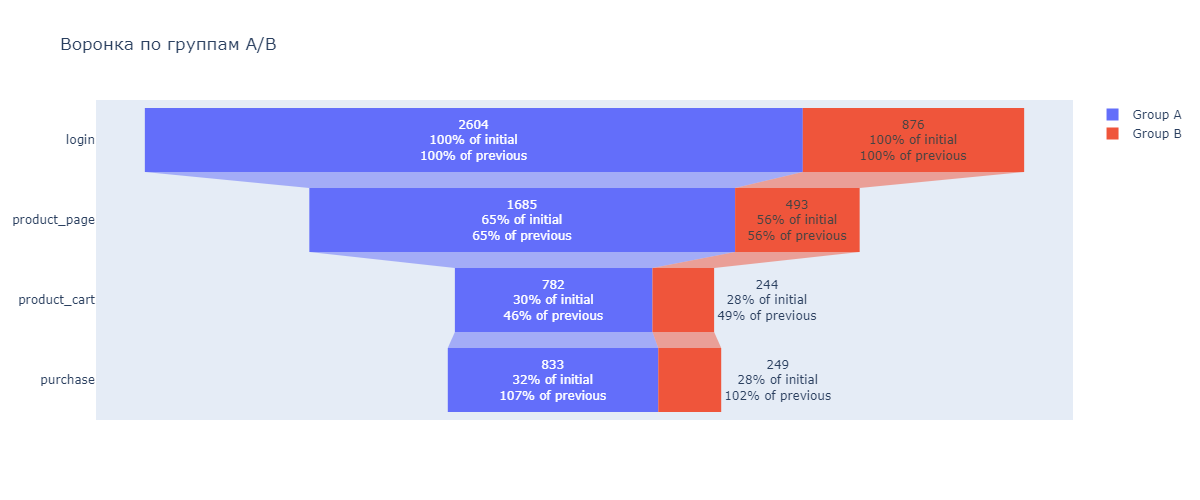

In [36]:
# построим графическую воронку продаж по группам А и B. 
fig = go.Figure()
fig.add_trace(go.Funnel(
    name='Group A',
    y = funnel_events['event_name'],
    x = funnel_events['A'],
    textposition = 'inside',
    textinfo = 'value+percent previous+percent initial'
    ))
fig.add_trace(go.Funnel(
    name='Group B',
    y = funnel_events['event_name'],
    x = funnel_events['B'],
    textposition = 'auto',
    textinfo = 'value+percent previous+percent initial'
    )) 
fig.update_layout(title_text='Воронка по группам А/В')
fig.show(renderer='png', width=1200, height=500)

In [37]:
# посчитаем среднюю выручку по группам.
print('в группе A:', round(users_events_rec.query('group=="A"')['details'].sum()
                    / users_events_rec.query('group=="A"')['user_id'].nunique(), 2))
print('в группе B:', round(users_events_rec.query('group=="B"')['details'].sum()
                    / users_events_rec.query('group=="B"')['user_id'].nunique(), 2))

в группе A: 22.16
в группе B: 16.27


<span style='color:#00541F'><b>ВЫВОД ПО РАЗДЕЛУ:</b></span><br>
- Среднее кол-во действий совершаемых пользователем группы A оказалось выше на 1, чем показатель группы B;
- На графике распределения кол-ва событий в группах по дням, можно заметить резкий рост активности группы А с <b>2020-12-14</b> по <b>2020-12-21</b>, затем С <b>2020-12-22</b> начинается планомерное снижение.<br>Данная предновогодняя активность является причиной серьезных искажений результатов.;
- Кол-во участников обеих тестируемых групп значительно ниже(<b>3481</b>), чем заявлено в техническом задании(<b>6000</b>);
- Распределение кол-ва участников по тестируемым группам сильно различается. Группа А - <b>2604</b>, группа B - <b>877</b>. Допустимая погрешность в  1%;
- Согласно ТЗ, ожидаемое улучшения конверсии группы B не менее, чем на 10% не состоялось. Показатели конверсии группы А значительно лучше, чем у конверсии группы B:
    - Просмотр карточек товаров - событие (*product_page*) - группа <b>А - 65%</b>, группа <b>B - 56%</b>;
    - Просмотр коризины (*product_cart*) - группа <b>А - 46%</b>, группа <b>B - 49%</b>;
    - Покупки (*purchase*) - группа <b>А - 107%</b>, группа <b>B - 102%</b>.
- До этапа покупки дошли <b>32%</b> группы А и <b>28%</b> группы B;
- Выручка группы А - <b>22.61</b>, группы B - <b>16.83</b>.

## Оценка результатов A/B-тестирования. ##

### Анализ результатов A/B-тестирования. ###

Ряд условий технического задания не были выполнены, следовательно А/В тест можно считаться несостоявшимся.
- По условию ТЗ Дата остановки - 2021-01-04, в наличии до 2020-12-30. Не хватает 5 дней;
- Ожидаемое кол-во участников тестируемых групп - 6000, в наличии 3481;
- Увеличение конверсии каждого шага воронки на 10% не было достигнуто;
- Контрольная группа А практически в 3 раза больше тестовой группы В. Подобное распределение искажает результаты;
- Присутствуют пересечения с маркетинговыми событиями в период предновогодних распродаж, что так же повлияет на результат.

### Проверка статистической разницы долей z-критерием. ###

Сформулируем гипотезы:

H0: Конверсии тестируемых групп A и B равны.<br>
Н1: Конверсии тестируемых групп A и B не равны.

Проверим статистическую разницу долей z-критерием.
Определим критический уровень статистической значимости alpha = 0.5.

In [38]:
# определим функцию для проверки гипотез.
def z_test(first_group, second_group, alpha_value):
    alpha = alpha_value
    event_name = funnel_events['event_name']
    
    for i in range(1,len(first_group)):
        successes = np.array([first_group[i], second_group[i]])
        trials = np.array([first_group[0], second_group[0]])
       
        # пропорция успехов в 1 группе.
        p1 = successes[0] / trials[0]  
        # пропорция успехов во 2 группе.
        p2 = successes[1] / trials[1]  
        
        # пропорция успехов в комбинированном датасете.
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) 
        # разница пропорций в датасетах
        difference = p1 - p2  
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения.
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1).
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        # введём поправку Бонферрони.
        bonferroni_alpha = alpha / 3
    
        print('Событие:', event_name[i])
        print('p-value =', p_value.round(3))
        if (p_value < bonferroni_alpha):
            print('Отвергаем нулевую гипотезу о равенстве конверсии в тестируемых группах')
        else:
            print('Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в тестируемых группах') 
            
        print('')

In [39]:
# применение функции.
z_test(funnel_events['A'], funnel_events['B'], 0.05)

Событие: product_page
p-value = 0.0
Отвергаем нулевую гипотезу о равенстве конверсии в тестируемых группах

Событие: product_cart
p-value = 0.222
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в тестируемых группах

Событие: purchase
p-value = 0.049
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в тестируемых группах



<span style='color:#00541F'><b>ВЫВОД ПО РАЗДЕЛУ:</b></span><br>
- Результаты статистического теста показали что, значимое различие между группами <b>А</b> и <b>В</b> присутствует в шаге воронки <b>product_page</b> - *просмотр карточки товара*;
- По остальным событиям (<b>product_cart</b> - *просмотр корзины*, <b>purchase</b> - *покупки*) нулевую гипотезу отвергнуть не получилось.

## Общий вывод. ##

В ходе анализа теста recommender_system_test сделаем следующие выводы:

<b>По результату исследовательского анализа данных:</b>
- Дата запуска и дата остановки набора новых пользователей - корректны;
- Дата остановки: <b>2020-12-30</b>, требуется <b>2021-01-04</b>.
- В наличии данные за период размером <b>23</b> дня;
- Было обнаружено <b>1</b> маркетинговое событие, которое непосредственно имеет влияние на поведение пользователей;
- В двух конкурирующих тестах участвуют одновременно  <b>1602</b> пользователя;
- Доля пользователей EU задействованных в тесте, от общего кол-ва пользователей EU - <b>15 %</b>;
- Количество участников теста <b>6701</b>, на <b>701</b> больше ожидаемого;
- Тестовые группы распределены не равномерно. Группа «A» - <b>57 %</b>, группа «B» - <b>43 %</b>. 

<b>По оценке результатов A/B - тестирования:</b>
- По условию ТЗ Дата остановки - <b>2021-01-04</b>, в наличии до <b>2020-12-30</b>. Не хватает 5 дней;
- Ожидаемое кол-во участников тестируемых групп - <b>6000</b>, в наличии <b>3481</b>;
- Увеличение конверсии каждого шага воронки на <b>10%</b> в течении 14 дней не было достигнуто;
- Контрольная группа А практически в <b>3</b> раза больше тестовой группы В. Подобное распределение искажает результаты;
- Присутствуют пересечения с маркетинговыми событиями в период предновогодних распродаж, что так же повлияет на результат;
- Результаты статистического теста показали что, значимая разница между группами <b>А</b> и <b>В</b> присутствует в шаге воронки <b>product_page</b> - *просмотр карточки товара*.

Тестирование проведено некорректно, с многочисленными нарушениями, результаты не стоит рассматривать как окончательные.<br> Рекомендуется провести повторное тестирование, в соответсвии с техническим заданием соблюдая методологию.

<b>Критерии успешного A/B-теста:</b>
- Количество пользователей в различных группах различается не более, чем на 1% или 0.5%

- Выдерженна запланированная длительность эксперимента. Рекомендованная длительность проведения теста не менее 2 недель

- Желательно, чтобы проведение теста не пересекалось с проведением других тестов. Особенно конкурирующего теста

- В анализ включены только те пользователи, которые могли быть затронуты тестируемыми изменениями

- Для всех групп фиксируются и отправляются в системы аналитики данные об одном и том же

- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости

- Попавший в одну из групп пользователь остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно

- Нельзя "добирать" выборки, чтобы получить значимый результат тестирования

- Нельзя "подглядывать" за результатами теста, не дожидаясь минимальной длительности теста и стабилизации метрик